# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [15]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
# 下面这个设定可以使notebook自动重载外部python 模块．
# 也就是说，当从外部文件引入的函数被修改之后，在notebook中调用这个函数，得到的被改过的函数．
%load_ext autoreload
%autoreload 2
# 加载 CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'


X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


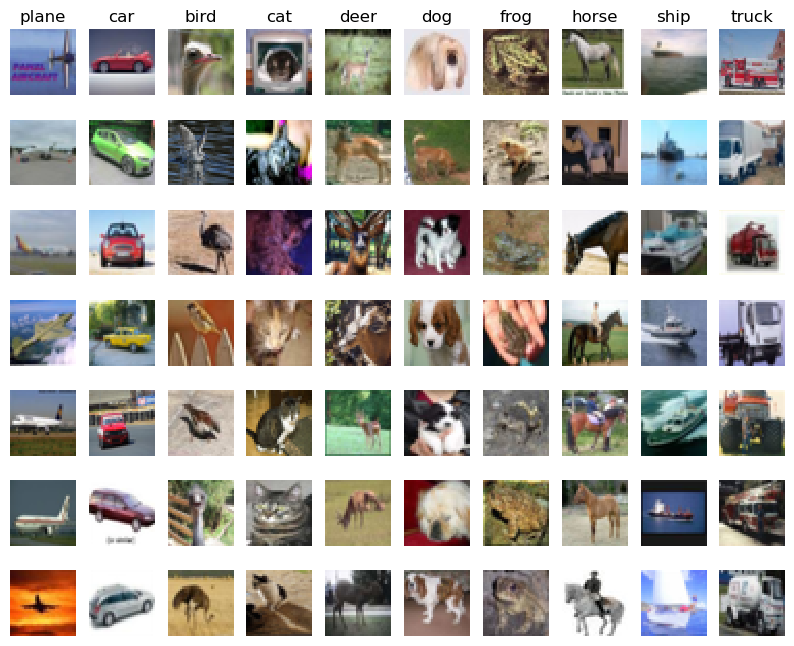

In [17]:
# 这里我们将训练集中每一类的样本都随机挑出几个进行展示
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        #每个子图索引：行*10（每行10个图片）+列*7（每列7个图片） +1是因为subplot的索引从1开始
        #i是第y类别选出来的7个里面的第i个，每个i都应该在新的一行里
        #y是第y个类别，每个类别在新的一列里
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
            #把此类别第一个的label作为这一列的title
plt.show()

In [18]:
# 为了更高效地运行我们的代码，这里取出一个子集进行后面的练习
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 将图像数据转置成二维的，原来是(50000, 32, 32, 3)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)
print(X_train)
print(X_test)

(5000, 3072) (500, 3072)
[[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [167. 163. 145. ...  42.  78.  84.]
 [154. 152. 125. ... 194. 247. 114.]
 [ 45.  32.  21. ... 156. 142. 100.]]
[[158. 112.  49. ...  21.  67. 110.]
 [235. 235. 235. ... 186. 200. 199.]
 [158. 190. 222. ...   7.   8.   7.]
 ...
 [ 74. 126. 176. ... 141. 199. 251.]
 [145. 162. 125. ... 117. 119. 105.]
 [185. 189. 188. ... 211. 212. 206.]]


In [19]:
from cs231n.classifiers import KNearestNeighbor

# 创建kNN分类器对象
# kNN 分类器不进行操作，只是将训练数据进行了简单的存储
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
print(classifier.X_train)
print(X_test)

[[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [167. 163. 145. ...  42.  78.  84.]
 [154. 152. 125. ... 194. 247. 114.]
 [ 45.  32.  21. ... 156. 142. 100.]]
[[158. 112.  49. ...  21.  67. 110.]
 [235. 235. 235. ... 186. 200. 199.]
 [158. 190. 222. ...   7.   8.   7.]
 ...
 [ 74. 126. 176. ... 141. 199. 251.]
 [145. 162. 125. ... 117. 119. 105.]
 [185. 189. 188. ... 211. 212. 206.]]


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [20]:
# 打开cs231n/classifiers/k_nearest_neighbor.py 并填写compute_distances_two_loops.

# 测试一下你的结果:
from cs231n.classifiers import KNearestNeighbor


In [21]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


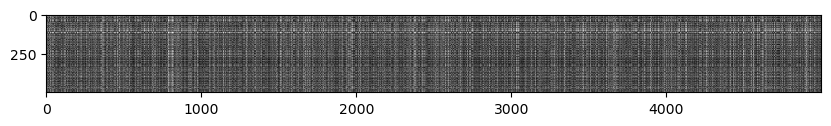

In [22]:
# 我们可以将距离矩阵进行可视化：其中每一行表示一个测试样本与所有训练样本的距离
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*



In [11]:
#  图中可以明显看出，有一些行或者列明显颜色较浅。（其中深色表示距离小，而浅色表示距离大） 
#  某些行颜色偏浅，表示测试样本与训练集中的所有样本差异较大，该测试样本可能明显过亮或过暗或者有色差。
# 某些列颜色偏浅，所有测试样本与该列表示的训练样本距离都较大，该训练样本可能明显过亮或过暗或者有色差。   

In [10]:
# 打开cs231n/classifiers/k_nearest_neighbor.py并实现 predict_labels 方法
# 这里我们将k设置为1 (也就是最临近算法）.
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [11]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [ ]:
1,3

In [12]:
# 现在我们将距离计算的效率提升一下，使用单层循环结构的计算方法。实现compute_distances_one_loop方法。
# Implement the function compute_distances_one_loop and run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# 为了保证向量化的代码运行正确，我们将运行结果与前面的方法的结果进行对比。对比两个矩阵是否相等的方法有很多，比较简单的一种是使用Frobenius范数。Frobenius范数表示的是两个矩阵所有元素的差值的均方根。或者说是将两个矩阵reshape成向量后，它们之间的欧氏距离
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# 完成完全向量化方式运行的compute_distances_no_loops方法
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# 下面我们对比一下各方法的执行速度
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 27.635894 seconds
One loop version took 44.510613 seconds
No loop version took 0.191456 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# 任务:                                                                        #
# 将训练数据切分成不同的折。切分之后,训练样本和对应的样本标签被包含在数组      #
# X_train_folds和y_train_folds之中，数组长度是折数num_folds。其中              #
# y_train_folds[i]是一个矢量，表示矢量X_train_folds[i]中所有样本的标签         #
# 提示: 可以尝试使用numpy的array_split方法。                                   #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
#将 X_train 沿着第一个轴（即行）分割成 5 个相等的子数组（按照顺序分）

#X_train_folds包含五个子数组，每个数组的形状都是1000*3072
y_train_folds = np.array_split(y_train, num_folds)
#y_train_folds包含五个子数组，每个数组的形状都是1000，
################################################################################
#                                 结束                                         #
################################################################################
# 我们将不同k值下的准确率保存在一个字典中。交叉验证之后，k_to_accuracies[k]保　
# 存了一个长度为折数的list，值为k值下的准确率．

k_to_accuracies = {}

################################################################################
# 任务:                                                                        #
# 通过k折的交叉验证找到最佳k值。对于每一个k值，执行kNN算法num_folds次，每一次  #
# 执行中，选择一折为验证集，其它折为训练集。将不同k值在不同折上的验证结果保    #
# 存在k_to_accuracies字典中。                                                  #
################################################################################
classifier = KNearestNeighbor()
for k in k_choices:
    #k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
    accuracies = np.zeros(num_folds)
    for fold in range(num_folds):
        temp_X = X_train_folds[:]
# X_train_folds[:]修改temp_X中的值不会影响X_train_folds。temp_X = X_train_folds的话修改temp_X中的值会影响X_train_folds
        temp_y = y_train_folds[:]
        X_validate_fold = temp_X.pop(fold)
        y_validate_fold = temp_y.pop(fold)
#运行结果是X_validate_fold就是fold的值，而temp_X删掉了第fold个子数组 

        temp_X = np.array([y for x in temp_X for y in x])
        temp_y = np.array([y for x in temp_y for y in x])
#  首先，for循环遍历temp_X中的每个元素x。
# 然后，又开启了一个for循环遍历x中的每一个元素y。
# 最后，将y作为一个元素添加到一个新的列表中。
# temp_y的形状是（4000,）
#temp_X（4000,3072）将temp_X 中的每个子数组展开成一个一维数组，然后用一个列表将这些一维数组组合成一个大的二维数组。
        classifier.train(temp_X, temp_y)

        y_test_pred = classifier.predict(X_validate_fold, k=k)
        num_correct = np.sum(y_test_pred == y_validate_fold)
        accuracy = float(num_correct) / len(y_test_pred)
        accuracies[fold] =accuracy
    k_to_accuracies[k] = accuracies
#     {k1:（0.9,0.8,0.5,0.6,0.7），k2:(),k3:()}
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# 输出准确率
for k in sorted(k_to_accuracies):
    #字典是无序的
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

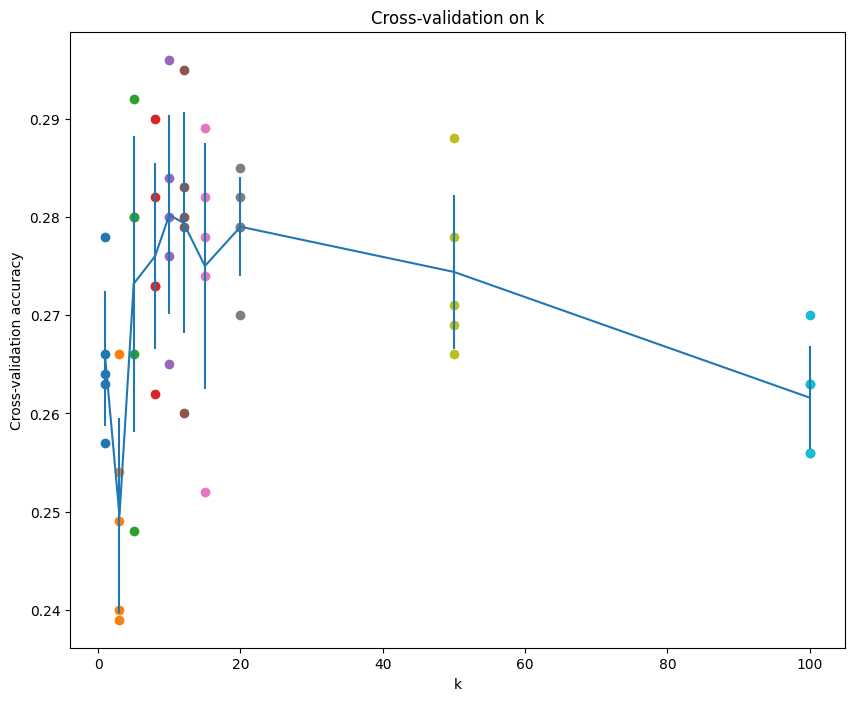

In [17]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 画出在不同k值下，误差均值和标准差
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [18]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



In [ ]:
4